In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [3]:
data = bd.bindome.datasets.SELEX.get_data()
# data[data['cycle'] == 'AF']
data

PRJEB3289
# filenames 68
PRJEB14744
# filenames 12
PRJEB9797
# filenames 184
PRJEB20112
# filenames 46


,filename,library,batch,cycle,tf.name,accession
0,ETS1_TGTACC30NCAG_AI_2.fastq.gz,TGTACC30NCAG,AI,2,ETS1,PRJEB3289
1,ELK1_TGAGTG20NTGA_AG_1.fastq.gz,TGAGTG20NTGA,AG,1,ELK1,PRJEB3289
2,ZeroCycle_TGAGTG20NTGA_0_0.fastq.gz,TGAGTG20NTGA,0,0,ZEROCYCLE,PRJEB3289
3,ELK1_TAGCAG30NACT_AI_2.fastq.gz,TAGCAG30NACT,AI,2,ELK1,PRJEB3289
4,ZeroCycle_TCCGTG20NTGC_0_0.fastq.gz,TCCGTG20NTGC,0,0,ZEROCYCLE,PRJEB3289
...,...,...,...,...,...,...
305,ZeroCycle_TACATC40NATA_0_0.fastq.gz,TACATC40NATA,0,0,ZEROCYCLE,PRJEB20112
306,ZeroCycle_TATACC40NGCC_0_0.fastq.gz,TATACC40NGCC,0,0,ZEROCYCLE,PRJEB20112
307,ZeroCycle_TGGTAC40NTCT_0_0.fastq.gz,TGGTAC40NTCT,0,0,ZEROCYCLE,PRJEB20112
308,ZeroCycle_TAGGAG40NAGT_0_0.fastq.gz,TAGGAG40NAGT,0,0,ZEROCYCLE,PRJEB20112


In [25]:
set(data['tf.name'])

{'ALX1',
 'ALX4',
 'EGR1',
 'ELF2',
 'ELF3',
 'ELF4',
 'ELK1',
 'ELK3',
 'ETS1',
 'ETV4',
 'ETV5',
 'ETV6',
 'FOXA1',
 'ZEROCYCLE'}

In [29]:
data[data['library'] == 'TTTGCC40NTGA']

,filename,library,batch,cycle,tf.name,accession
85,ETV4_eDBD_1_KS_TTTGCC40NTGA.fastq.gz,TTTGCC40NTGA,eDBD,1,ETV4,PRJEB9797
99,ETV4_eDBD_2_KS_TTTGCC40NTGA.fastq.gz,TTTGCC40NTGA,eDBD,2,ETV4,PRJEB9797
125,ETV4_eDBD_4_KS_TTTGCC40NTGA.fastq.gz,TTTGCC40NTGA,eDBD,4,ETV4,PRJEB9797
128,ETV4_eDBD_3_KS_TTTGCC40NTGA.fastq.gz,TTTGCC40NTGA,eDBD,3,ETV4,PRJEB9797
290,ZeroCycle_TTTGCC40NTGA_0_0.fastq.gz,TTTGCC40NTGA,0,0,ZEROCYCLE,PRJEB20112


In [4]:
tf_names = ['ETS1', 'ELF2', 'ELK3', 'ETV4']
libraries = ['TGTAAA20NGA', 'TAGGAG40NAGT', 'TGTCAG40NGAC', 'TTTGCC40NTGA']
count_tables = []

for tf, lib in zip(tf_names, libraries):
    print('loading', tf, ':', lib)
    grp = data[data['library'] == lib]

    data_sel_tf = grp[(grp['tf.name'] == tf)]
    data_sel_zero = grp[(grp['cycle'] == 0) & grp['library'].isin(set(grp[grp['tf.name'] == tf]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]

    print(data_sel_tf.shape[0], data_sel_zero.shape[0])
    if data_sel_tf.shape[0] == 0 or data_sel_zero.shape[0] == 0:
        continue

    reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
    reads_zero = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel_zero, library=lib)

    print(reads_tf.keys(), reads_zero.keys())

    for k_r0 in reads_zero:
        if 'ZeroCycle_TGTAAA20NGA_0_0' in k_r0:
            continue
        
        n_rounds = len(reads_tf.keys())
        print(n_rounds)

        # combine all the positive round data
        df2 = []
        for k in reads_tf.keys():
            df = reads_tf[k]
            df['k'] = k
            df2.append(df)
        df = pd.concat(df2)
        df = df.pivot('seq', 'k', 'counts').fillna(0).reset_index()

        next_data = reads_zero[k_r0].merge(df, on='seq', how='outer').fillna(0) # .astype(int)

        new_cols = ['seq', k_r0] + list(df.columns[1:])
        next_data.columns = new_cols
        for i, k in enumerate(next_data.columns[1:]):
            next_data[k] = next_data[k].astype(int)
            next_data[i] = next_data[k].astype(int)

        next_data['sum'] = next_data[[i for i in range(0, n_rounds + 1)]].sum(axis=1).values
        next_data = next_data.sort_values('sum', ascending=False)
        
        print('sampling from top n reds in round 1 ...')
        print(next_data.shape)
        next_data = next_data.head(50000).reset_index(drop=True)
        print(next_data.shape)
        
        count_tables.append(next_data)

loading ETS1 : TGTAAA20NGA
4 2
dict_keys(['ETS1_TGTAAA20NGA_AF_1', 'ETS1_TGTAAA20NGA_AF_3', 'ETS1_TGTAAA20NGA_AF_4', 'ETS1_TGTAAA20NGA_AF_2']) dict_keys(['ZeroCycle_TGTAAA20NGA_0_0', 'ZeroCycle_ES0_TGTAAA20NGA_0'])
4
sampling from top n reds in round 1 ...
(772868, 12)
(50000, 12)
loading ELF2 : TAGGAG40NAGT
4 1
dict_keys(['ELF2_eDBD_2_KAN_TAGGAG40NAGT', 'ELF2_eDBD_4_KAN_TAGGAG40NAGT', 'ELF2_eDBD_3_KAN_TAGGAG40NAGT', 'ELF2_eDBD_1_KAN_TAGGAG40NAGT']) dict_keys(['ZeroCycle_TAGGAG40NAGT_0_0'])
4
sampling from top n reds in round 1 ...
(1604500, 12)
(50000, 12)
loading ELK3 : TGTCAG40NGAC
4 1
dict_keys(['ELK3_FL_2_KX_TGTCAG40NGAC', 'ELK3_FL_1_KX_TGTCAG40NGAC', 'ELK3_FL_3_KX_TGTCAG40NGAC', 'ELK3_FL_4_KX_TGTCAG40NGAC']) dict_keys(['ZeroCycle_TGTCAG40NGAC_0_0'])
4
sampling from top n reds in round 1 ...
(971108, 12)
(50000, 12)
loading ETV4 : TTTGCC40NTGA
4 1
dict_keys(['ETV4_eDBD_1_KS_TTTGCC40NTGA', 'ETV4_eDBD_2_KS_TTTGCC40NTGA', 'ETV4_eDBD_4_KS_TTTGCC40NTGA', 'ETV4_eDBD_3_KS_TTTGCC40NTGA'])

In [6]:
concat_list = []
for i in range(len(count_tables)):
    concat_list.append(count_tables[i][['seq', 0, 1, 2, 3, 4]])
next_data = pd.concat(concat_list).reset_index(drop=True)
next_data['batch'] = np.repeat(np.arange(4), 50000)
next_data

,seq,0,1,2,3,4,batch
0,CCGGAAGTACTTCCGCCCAT,0,0,8,1110,4394,0
1,CGGAAGCACTTCCGGTGTGA,0,0,12,1288,3820,0
2,CCGGATGCGCTTCCGCCCAC,0,0,7,1014,2629,0
3,CCGGATACGCATCCGGCCAT,0,0,13,794,1869,0
4,CCGGAAGTGTATCCTGCCTT,0,0,11,808,1612,0
...,...,...,...,...,...,...,...
199995,GAAGCGTGCTTCCGGTGAACGCTAGTGAGATCCGGTCACT,0,0,0,0,2,3
199996,GAAGCGTGCGGAAGGTGGCTACCGGAAACGGAACACATCC,0,0,1,1,0,3
199997,GAAGCGTGCGCAGAAACGGTTAAGCAAACCGGAAGTAAGG,0,0,1,0,1,3
199998,GAAGCGTCGCGACAGGAAGCGCTGGAACCACATCCGGTGT,0,0,0,0,2,3


In [7]:
set(next_data['seq'].str.len())

{20, 40}

In [8]:
dataset = mb.datasets.SelexDataset(next_data, max_length=40, n_rounds=4)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [47]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 16, 16, 16, 8, 8, 8], n_rounds=4, n_libraries=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

In [48]:
l2 = mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=20, log_each=10)

Epoch:  1, Loss: -0.308
Epoch: 11, Loss: -0.437
Epoch: 21, Loss: -0.437
Epoch: 31, Loss: -0.431
Epoch: 41, Loss: -0.438


In [54]:
model.load_state_dict(model.best_model_state)

<All keys matched successfully>

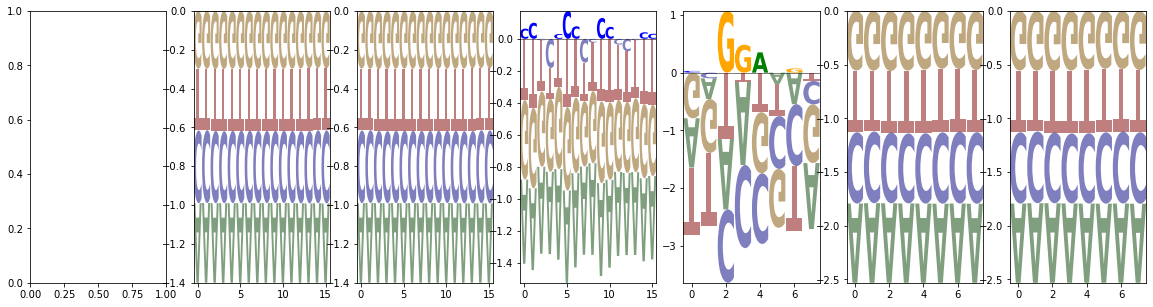

In [55]:
mb.pl.conv_mono(model)

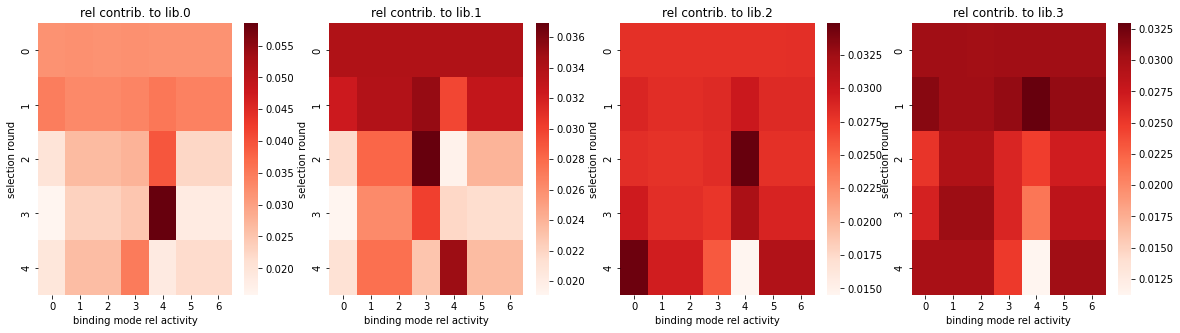

In [56]:
mb.pl.plot_activities(model) #tf_names = ['ETS1', 'ELF2', 'ELK3', 'ETV4']

In [16]:
kernels = [0, 16, 16]
model = mb.models.DinucSelex(use_dinuc=False, kernels=kernels, n_rounds=4, n_libraries=4).to(device) #, n_rounds=n_rounds)
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

Epoch:  1, Loss: 0.281
Epoch:  6, Loss: -0.365
Epoch: 11, Loss: -0.367


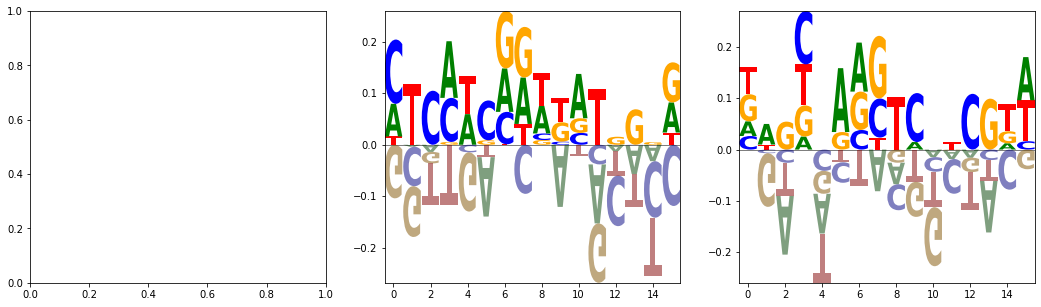

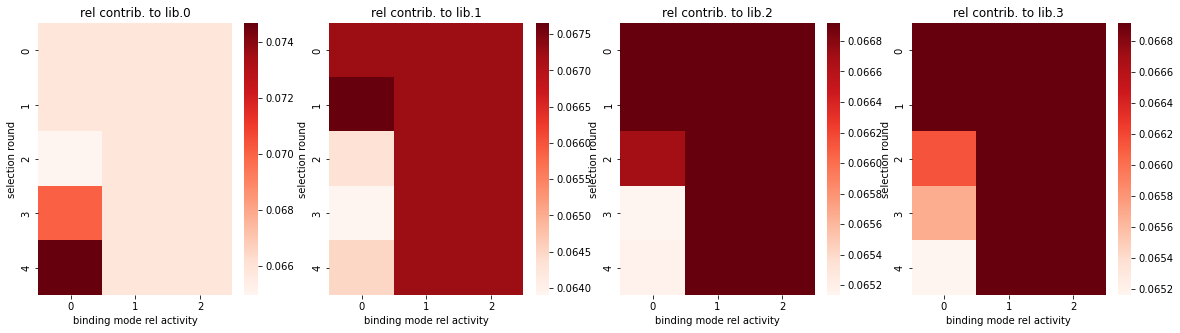

[Parameter containing:
tensor([[ 7.0526e-05, -3.8502e-04, -1.3841e-02,  6.1700e-02,  1.2558e-01],
        [-9.0234e-07,  6.1846e-03, -4.4124e-02, -5.0812e-02, -4.1542e-02],
        [-1.5808e-05,  1.8751e-05, -3.2594e-03, -2.6951e-02, -2.6466e-02],
        [ 8.5627e-08,  5.0429e-06, -1.1577e-02, -1.8645e-02, -2.6579e-02]],
       requires_grad=True), Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])]
Epoch:  1, Loss: -0.378
Epoch:  6, Loss: -0.376


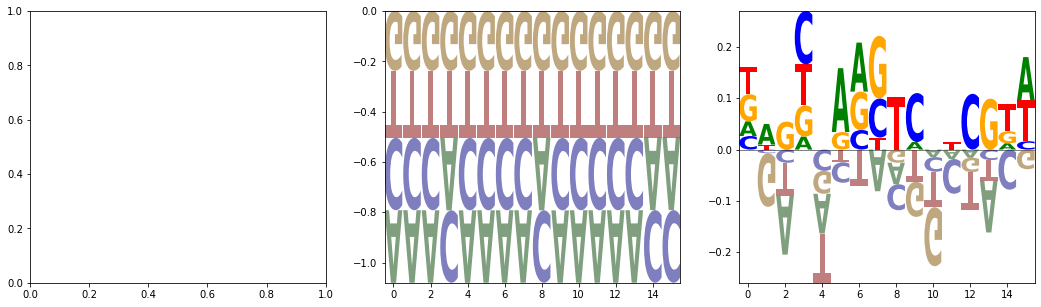

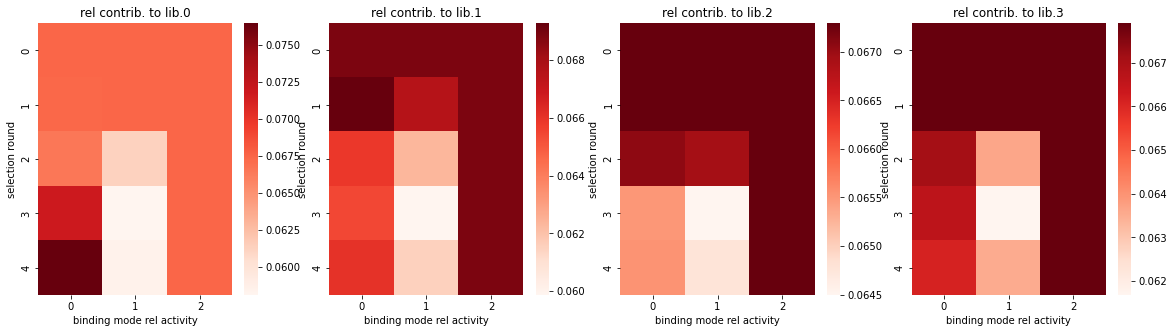

[Parameter containing:
tensor([[ 7.0526e-05, -3.8502e-04, -1.3841e-02,  6.1700e-02,  1.2558e-01],
        [-9.0234e-07,  6.1846e-03, -4.4124e-02, -5.0812e-02, -4.1542e-02],
        [-1.5808e-05,  1.8751e-05, -3.2594e-03, -2.6951e-02, -2.6466e-02],
        [ 8.5627e-08,  5.0429e-06, -1.1577e-02, -1.8645e-02, -2.6579e-02]]), Parameter containing:
tensor([[ 1.2119e-05,  6.3871e-04, -9.6005e-02, -1.4894e-01, -1.4204e-01],
        [ 4.8243e-06, -1.8082e-02, -9.9333e-02, -1.3968e-01, -1.1228e-01],
        [-6.4517e-06,  7.5101e-07, -5.3245e-03, -4.2462e-02, -3.8057e-02],
        [ 2.0749e-07,  1.3113e-06, -6.5009e-02, -9.6187e-02, -6.6536e-02]],
       requires_grad=True), Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])]
Epoch:  1, Loss: -0.388
Epoch:  6, Loss: -0.441
Epoch: 11, Loss: -0.440
Epoch: 16, Loss: -0.443


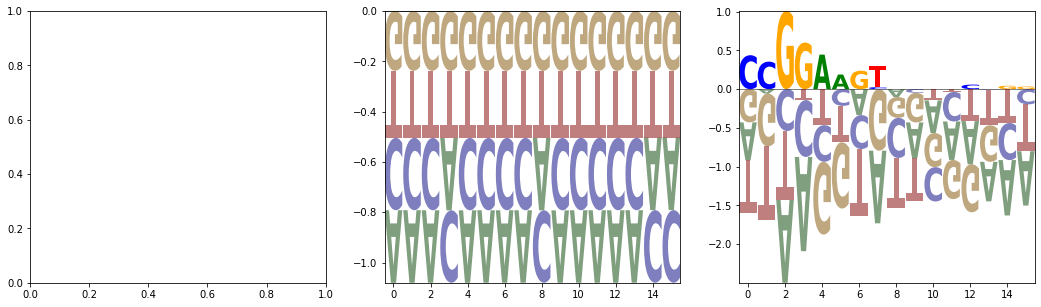

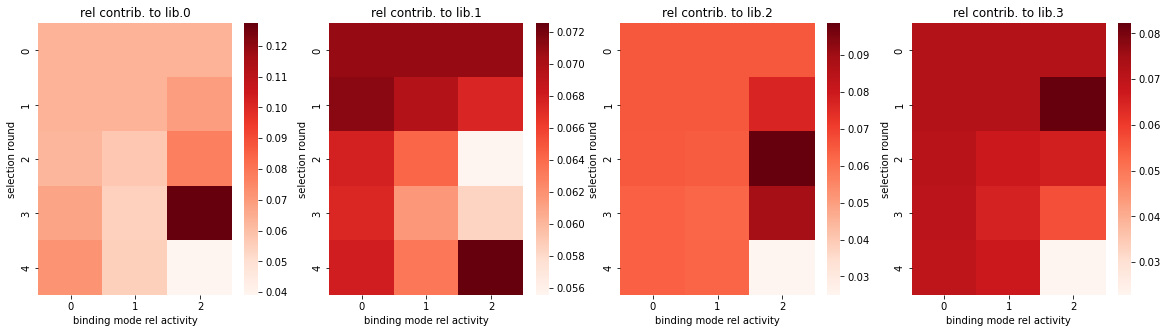

[Parameter containing:
tensor([[ 7.0526e-05, -3.8502e-04, -1.3841e-02,  6.1700e-02,  1.2558e-01],
        [-9.0234e-07,  6.1846e-03, -4.4124e-02, -5.0812e-02, -4.1542e-02],
        [-1.5808e-05,  1.8751e-05, -3.2594e-03, -2.6951e-02, -2.6466e-02],
        [ 8.5627e-08,  5.0429e-06, -1.1577e-02, -1.8645e-02, -2.6579e-02]]), Parameter containing:
tensor([[ 1.2119e-05,  6.3871e-04, -9.6005e-02, -1.4894e-01, -1.4204e-01],
        [ 4.8243e-06, -1.8082e-02, -9.9333e-02, -1.3968e-01, -1.1228e-01],
        [-6.4517e-06,  7.5101e-07, -5.3245e-03, -4.2462e-02, -3.8057e-02],
        [ 2.0749e-07,  1.3113e-06, -6.5009e-02, -9.6187e-02, -6.6536e-02]]), Parameter containing:
tensor([[ 2.4563e-04,  8.7309e-02,  1.9915e-01,  6.9674e-01, -4.8319e-01],
        [ 1.1057e-04, -4.9843e-02, -2.4376e-01, -1.9292e-01,  2.3085e-02],
        [-5.1590e-05,  1.6550e-01,  4.1272e-01,  3.1312e-01, -9.6117e-01],
        [ 2.9293e-04,  1.3385e-01, -8.2693e-02, -2.3479e-01, -1.1475e+00]],
       requires_grad=True)]


In [17]:
for i in range(len(kernels)):
    for j in range(len(kernels)):
        mb.tl.update_grad(model, j, j==i)
    l2 = mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=200, early_stopping=5, log_each=5)
    mb.pl.conv_mono(model)
    mb.pl.plot_activities(model)
    print(list(model.log_activities))